<a href="https://colab.research.google.com/github/GIS-ZhangZhen/MangroveGreenness/blob/main/%E5%9C%B0%E5%9B%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
!pip install cartopy==0.18.0
!pip install rasterio

Selecting previously unselected package python-pkg-resources.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../00-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../01-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../02-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../03-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../04-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-numpy.
Preparing to unpack .../05-python

In [1]:
import pandas
from osgeo import gdal
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context("notebook")
# plt.rcParams['font.family'] = ['Arial']
# font = font_manager.FontProperties(family='Arial')

# 1.IAV空间图
绘制0.5°格网下MGF和EBF的IAV，由CV和STD两个指标表示。

## 1.1 CV

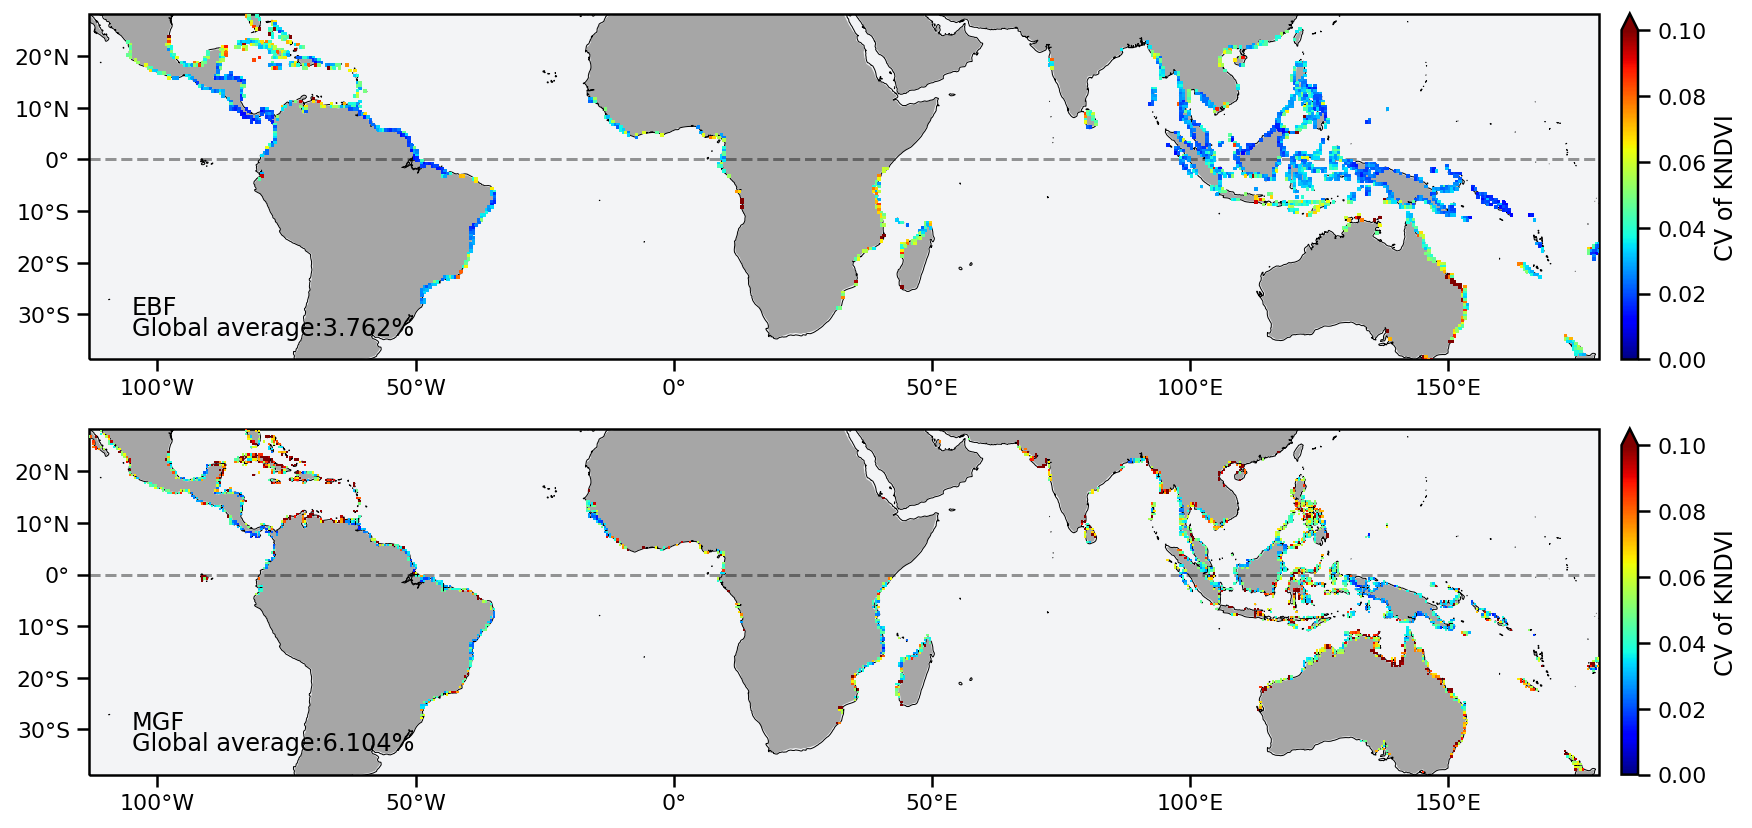

In [6]:
EBF = xr.open_dataset('/content/drive/MyDrive/Greenness/CV/KNDVI_EBF.nc')
MGF = xr.open_dataset('/content/drive/MyDrive/Greenness/CV/KNDVI_MGF.nc')
lon = EBF.x.data
lat = EBF.y.data
labels = ['EBF','MGF']

fig = plt.figure(figsize=(20,7))
plt.rcParams["font.family"] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
proj = ccrs.PlateCarree()
for i,data in enumerate([EBF,MGF]):
  ax = fig.add_subplot(2,1,1+i, projection=proj)
  ax.set_extent([lon.min(),lon.max(),lat.min(),lat.max()],proj)
  ax.coastlines(resolution = '50m',color='k',zorder=1,lw=0.5)
  ax.add_feature(cfeature.LAND,color='#a6a6a6')
  ax.add_feature(cfeature.OCEAN,color='#f3f4f6')
  # ax.set_title('EBF')
  
  
  # map_ivt = ax.imshow(data.EVI.data,extent=[lon.min(),lon.max(),lat.min(),lat.max()],cmap='jet',vmax=0.1,vmin=0,zorder=3)
  map_ivt = data.KNDVI.plot(cmap='jet',vmax=0.1,vmin=0 ,zorder=3,cbar_kwargs={
        "alpha": 0.5,
        'label': 'CV of KNDVI',
        'pad':0.01
    })
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.text(-105,-30,labels[i],fontsize=12)
  ax.text(-105,-34,'Global average:'+str(np.around(np.nanmean(data.KNDVI.data.flatten())*100,decimals=3))+'%',fontsize=12)
  plt.axhline(y=0,ls="--",c="k",alpha=0.4)
  ax.set_xticks(np.arange(-100,160,50), crs=ccrs.PlateCarree())
  ax.set_yticks(np.arange(-30,21,10), crs=ccrs.PlateCarree())
  lon_formatter = LongitudeFormatter(zero_direction_label=False)
  lat_formatter = LatitudeFormatter()
  ax.xaxis.set_major_formatter(lon_formatter)
  ax.yaxis.set_major_formatter(lat_formatter)
# position = fig.add_axes([0.8, 0.123, 0.01, 0.75 ])#位置[左,下,宽度,高度]
# cb = fig.colorbar(map_ivt, cax=position, orientation='vertical',extend='max')
# plt.subplots_adjust(wspace =0.1, hspace =0.12)
# plt.suptitle('Coefficient of variation')
# plt.savefig('/content/drive/MyDrive/Greenness/FigureCollection/EBF_annualDifference.png',dpi=600,bbox_inches='tight')
plt.show()

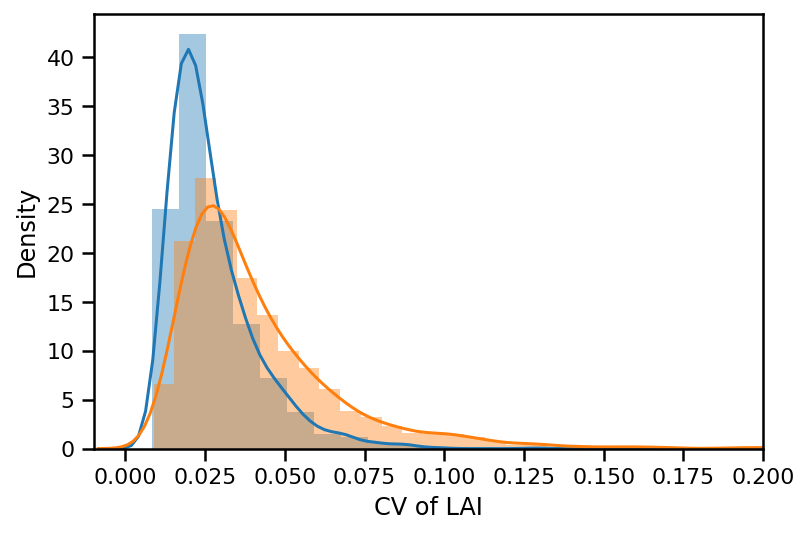

In [5]:
sns.distplot(EBF.NIRv.data.flatten())
sns.distplot(MGF.NIRv.data.flatten())
plt.xlim(-0.01,0.2)
plt.xlabel('CV of LAI');

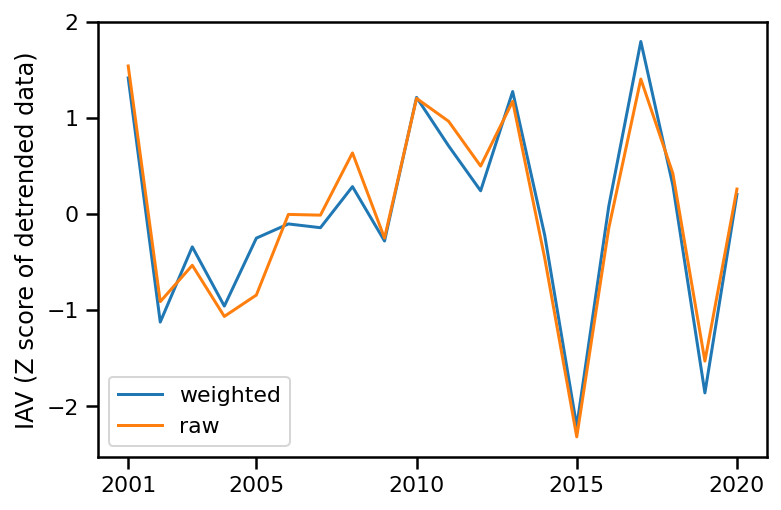

In [83]:
from sklearn.linear_model import LinearRegression
vi='EVI'
weight_EBF = xr.open_rasterio('/content/drive/MyDrive/Greenness/weight/VI_EBF_05deg.tif')
weight_EBF = weight_EBF.where(weight_EBF>0)
weight_MGF = xr.open_rasterio('/content/drive/MyDrive/Greenness/weight/VI_MGF_05deg.tif')
weight_MGF = weight_MGF.where(weight_MGF>0)
EBF = xr.open_dataset('/content/drive/MyDrive/Greenness/VI/{0}_EBF_05deg.nc'.format(vi))
MGF = xr.open_dataset('/content/drive/MyDrive/Greenness/VI/{0}_MGF_05deg.nc'.format(vi))
EBF = EBF.where(EBF>0)
MGF = MGF.where(MGF>0)
EBF = EBF.rename({'LAI':vi})
MGF = MGF.rename({'LAI':vi})
t= np.arange(0,20,1)
t = t.reshape(-1,1)

weighted = weight_EBF*EBF
weighted_annual = weighted.sum(dim=['x','y'])/1000000
x = weighted_annual[vi].data[0]
x = x.reshape(-1,1)
model = LinearRegression()
model.fit(t,x)
trend = model.predict(t)
detrended = x-trend
plt.plot((detrended-detrended.mean())/detrended.std(),label='weighted')

annual = EBF.mean(dim=['x','y'])/1000
x2 = annual[vi].data
x2 = x2.reshape(-1,1)
model2 = LinearRegression()
model2.fit(t,x2)
trend2 = model2.predict(t)
detrended2 = x2-trend2
plt.plot((detrended2-detrended2.mean())/detrended2.std(),label='raw')
plt.legend();
plt.ylabel('IAV (Z score of detrended data)')
plt.xticks([0,4,9,14,19],[2001,2005,2010,2015,2020]);

In [81]:
weighted

<xarray.Dataset>
Dimensions:  (band: 1, time: 20, x: 586, y: 135)
Coordinates:
  * y        (y) float64 28.25 27.75 27.25 26.75 ... -37.25 -37.75 -38.25 -38.75
  * x        (x) float64 -113.2 -112.8 -112.2 -111.8 ... 177.8 178.2 178.8 179.2
  * time     (time) int64 2001 2002 2003 2004 2005 ... 2016 2017 2018 2019 2020
  * band     (band) int64 1
Data variables:
    LAI      (band, y, x, time) float32 nan nan nan nan nan ... nan nan nan nan

# 2.变化趋势图

In [2]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
clist = ['#2d112e','#c05561','white','#2c9480','#050b23']
newcmp = LinearSegmentedColormap.from_list('chaos',clist)
cmaplist = [newcmp(i) for i in range(newcmp.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, newcmp.N)
bounds = np.linspace(-40, 40, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
norm = mpl.colors.TwoSlopeNorm(vmin=-40, vcenter=0, vmax=40)

In [3]:
def k_cor(vector,y):
    xx=vector.copy()
    xx[(xx<0)|(xx>10000)]=0
    co = np.count_nonzero(xx)
    if co < 15: 
        return np.nan,np.nan
    xx_0= xx[xx != 0]
    xx[xx==0] = np.nanmean(xx_0)
    tau, p_value = stats.kendalltau(xx, y)
    slope = stats.mstats.theilslopes(xx)
    return slope[0], p_value

def kendall_correlation(x,y,dim='time'):
    return xr.apply_ufunc(
        k_cor, x , y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[] for _ in range(2)],  
        vectorize=True,
        dask='parallelized'
        )

def Trend(vi,ds):
    dim = 'time'
    x = xr.DataArray(ds[dim].data, dims=dim,
                    coords={dim: ds[dim]}) 
    encoding =  {vi: {"dtype": "f4",'zlib': True,"complevel": 9}}
    r,p = kendall_correlation(ds, x,dim)
    r_sig10 = xr.where(p<=0.1,r,np.nan)
    r_sig5 = xr.where(p<=0.05,r,np.nan)
    return r_sig10,r_sig5,r

In [8]:
vi = 'LAI'
EBF = xr.open_dataset('/content/drive/MyDrive/Greenness/VI/{0}_EBF_05deg.nc'.format(vi))
MGF = xr.open_dataset('/content/drive/MyDrive/Greenness/VI/{0}_MGF_05deg.nc'.format(vi))
EBF = EBF.where(EBF>0)
MGF = MGF.where(MGF>0)
lat = EBF.y.data
lon = EBF.x.data
trends_EBF = Trend(vi,EBF)
trends_MGF = Trend(vi,MGF)

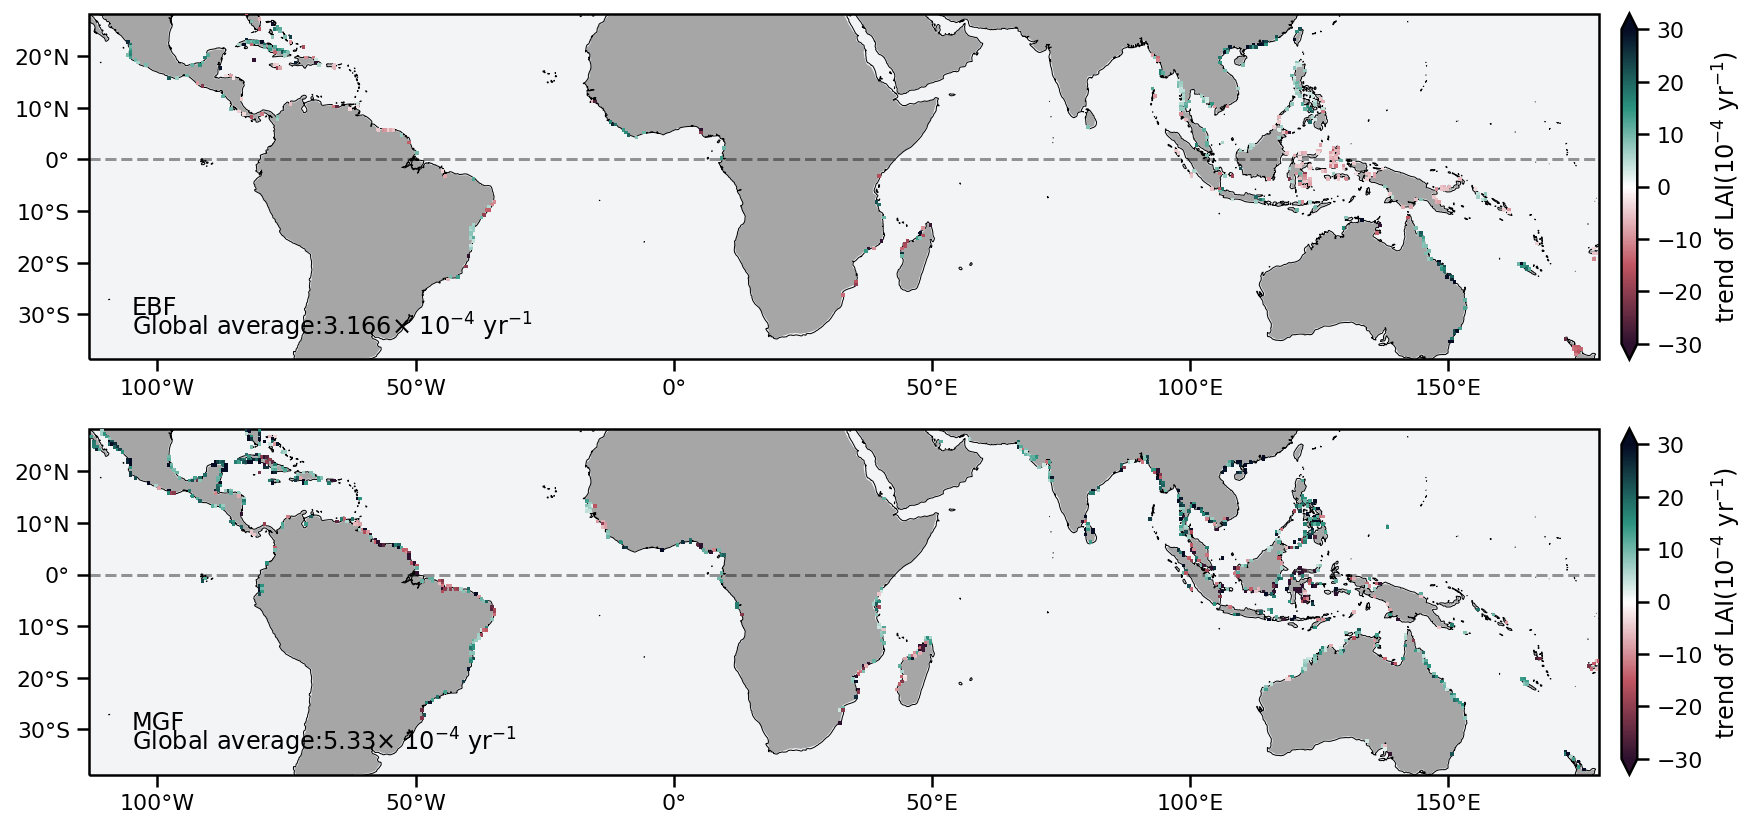

In [9]:
labels = ['EBF','MGF']
fig = plt.figure(figsize=(20,7))
plt.rcParams["font.family"] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
proj = ccrs.PlateCarree()
for i,data in enumerate([trends_EBF[0],trends_MGF[0]]):
  ax = fig.add_subplot(2,1,1+i, projection=proj)
  ax.set_extent([lon.min(),lon.max(),lat.min(),lat.max()],proj)
  ax.coastlines(resolution = '50m',color='k',zorder=1,lw=0.5)
  ax.add_feature(cfeature.LAND,color='#a6a6a6')
  ax.add_feature(cfeature.OCEAN,color='#f3f4f6')

  map_ivt = data[vi].plot(cmap=cmap,vmax=30,vmin=-30,zorder=3,cbar_kwargs={
        'label': 'trend of '+vi+'(10$^{-4}$ yr$^{-1}$)',
        'pad':0.01
    })
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.text(-105,-30,labels[i],fontsize=12)
  ax.text(-105,-34,'Global average:'+str(np.around(np.nanmean(data[vi].data.flatten()),decimals=3))+'× 10$^{-4}$ yr$^{-1}$',fontsize=12)
  plt.axhline(y=0,ls="--",c="k",alpha=0.4)
  ax.set_xticks(np.arange(-100,160,50), crs=ccrs.PlateCarree())
  ax.set_yticks(np.arange(-30,21,10), crs=ccrs.PlateCarree())
  lon_formatter = LongitudeFormatter(zero_direction_label=False)
  lat_formatter = LatitudeFormatter()
  ax.xaxis.set_major_formatter(lon_formatter)
  ax.yaxis.set_major_formatter(lat_formatter)

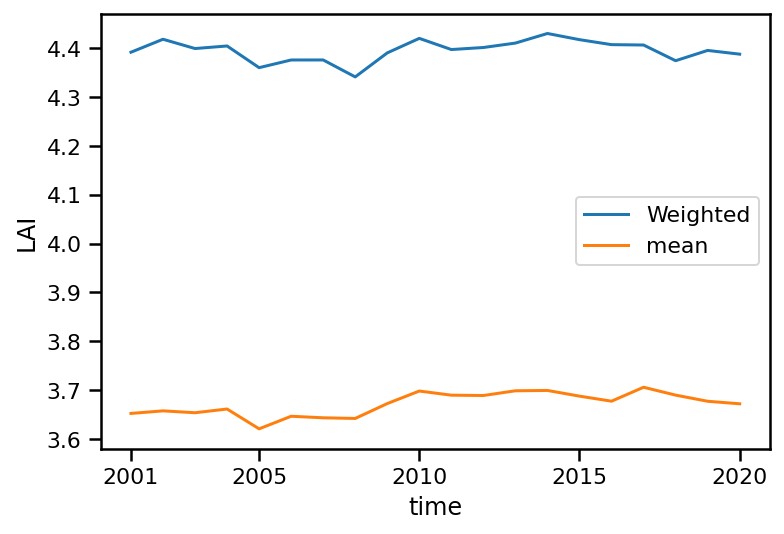

In [13]:
weight_EBF = xr.open_rasterio('/content/drive/MyDrive/Greenness/weight/LAI_EBF_05deg.tif')
weight_EBF = weight_EBF.where(weight_EBF>0)
weight_MGF = xr.open_rasterio('/content/drive/MyDrive/Greenness/weight/LAI_MGF_05deg.tif')
weight_MGF = weight_MGF.where(weight_MGF>0)

weighted = weight_MGF*MGF
weighted_annual = weighted.sum(dim=['x','y'])/1000000
annual = MGF.mean(dim=['x','y'])/1000
weighted_annual[vi].plot(label='Weighted')
annual[vi].plot(label='mean')
plt.legend();
plt.xticks([2001,2005,2010,2015,2020]);

In [86]:
green_EBF = weight_EBF[0].where(trends_EBF[0]>0)
brown_EBF = weight_EBF[0].where(trends_EBF[0]<0)
print(green_EBF.sum(dim=['x','y'])/1000)
print(brown_EBF.sum(dim=['x','y'])/1000)

green_MGF = weight_MGF[0].where(trends_MGF[0]>0)
brown_MGF = weight_MGF[0].where(trends_MGF[0]<0)
print(green_MGF.sum(dim=['x','y'])/1000)
print(brown_MGF.sum(dim=['x','y'])/1000)

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    band     int64 1
Data variables:
    LAI      float64 0.3637
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    band     int64 1
Data variables:
    LAI      float64 0.03484
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    band     int64 1
Data variables:
    LAI      float64 0.387
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    band     int64 1
Data variables:
    LAI      float64 0.1616


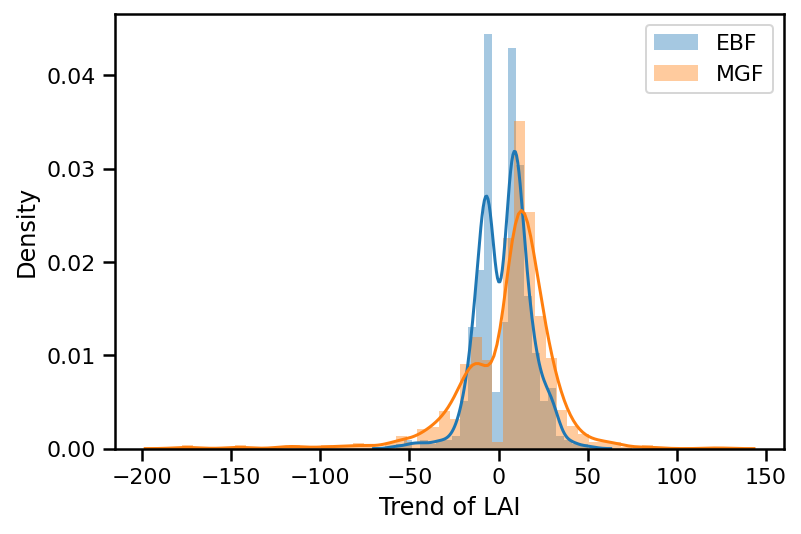

In [14]:
sns.distplot(trends_EBF[0][vi].data.flatten(),label = 'EBF')
sns.distplot(trends_MGF[0][vi].data.flatten(),label='MGF')
# plt.xlim(-0.01,0.2)
plt.xlabel('Trend of '+vi);
plt.legend();

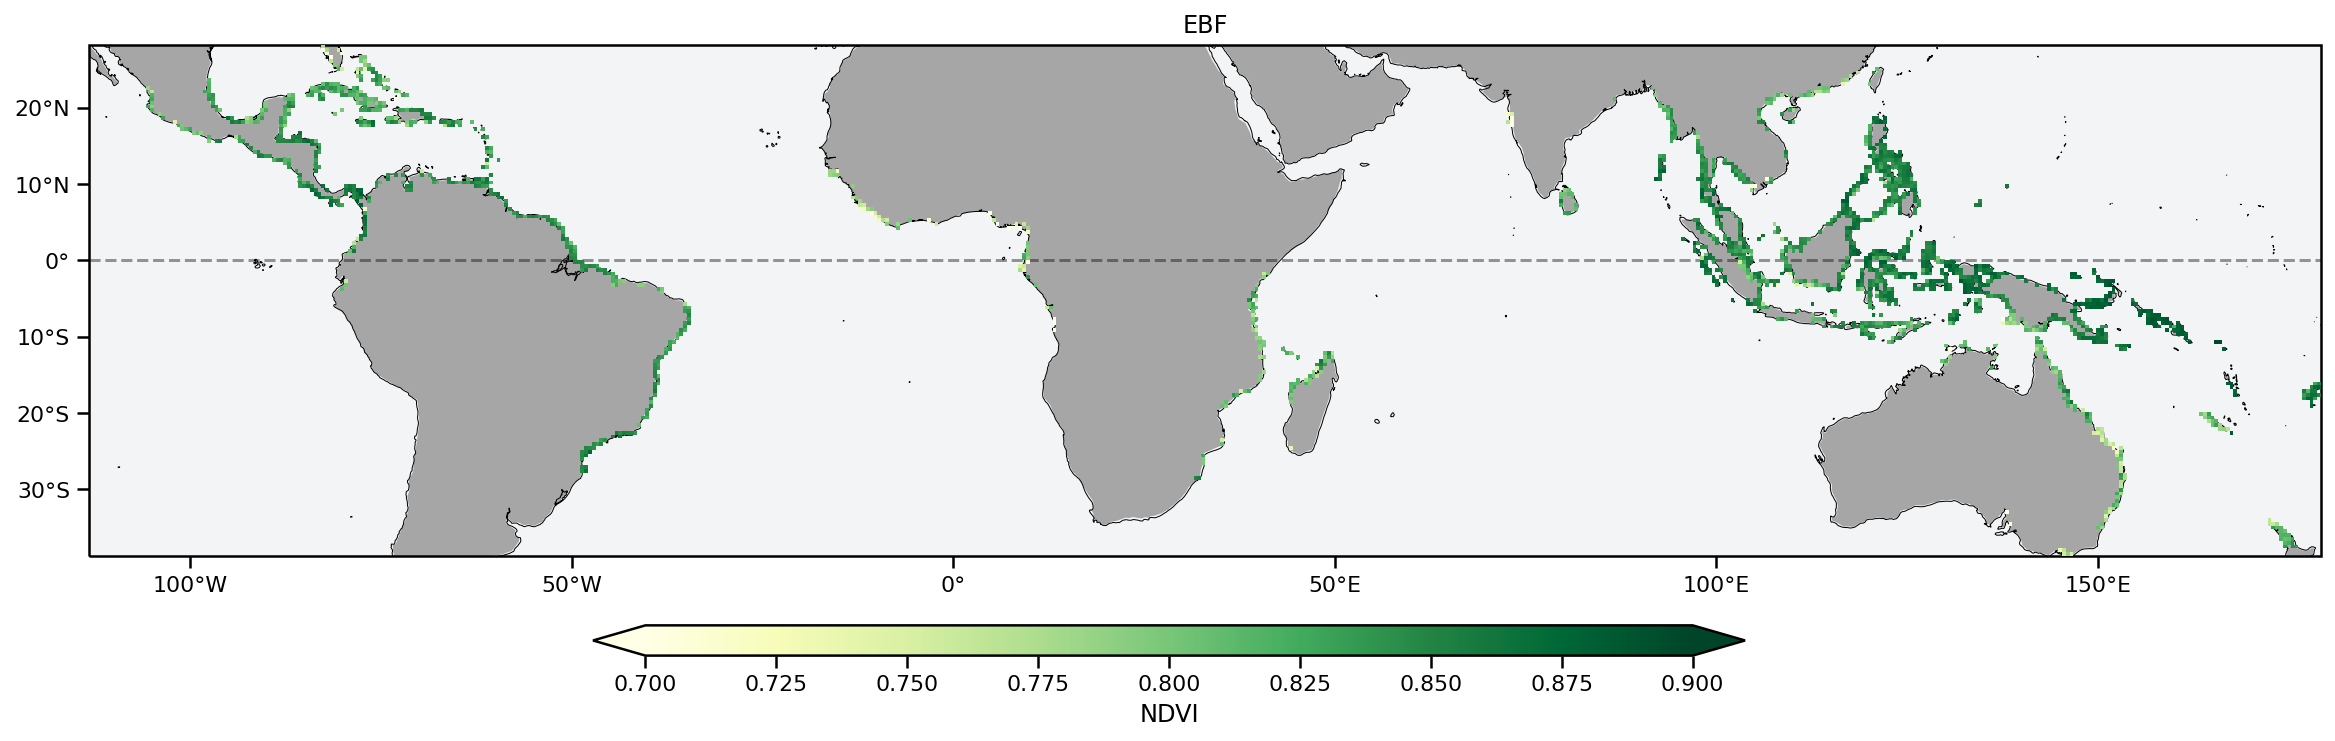

In [ ]:
EBF = xr.open_dataset('/content/drive/MyDrive/Greenness/EBF/NDVI_EBF_05deg.nc')
lon = EBF.x.data
lat = EBF.y.data
mean_EBF = EBF.mean(dim='time')
mean_EBF = mean_EBF.where(mean_EBF>0)
mean_EBF = mean_EBF.NDVI/10000

fig = plt.figure(figsize=(20,7))
plt.rcParams["font.family"] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
proj = ccrs.PlateCarree()
ax = fig.add_subplot(111, projection=proj)
ax.set_extent([lon.min(),lon.max(),lat.min(),lat.max()],proj)
ax.coastlines(resolution = '50m',color='k',zorder=1,lw=0.5)
ax.add_feature(cfeature.LAND,color='#a6a6a6')
ax.add_feature(cfeature.OCEAN,color='#f3f4f6')
ax.set_title('EBF')
map_ivt = ax.imshow(mean_EBF,extent=[lon.min(),lon.max(),lat.min(),lat.max()],cmap='YlGn',vmax=0.9,vmin=0.7 ,aspect='equal',zorder=3)
plt.axhline(y=0,ls="--",c="k",alpha=0.4)
ax.set_xticks(np.arange(-100,160,50), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-30,21,10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
position = fig.add_axes([0.3, 0.15, 0.4, 0.03 ])#位置[左,下,右,上]
cb = fig.colorbar(map_ivt, cax=position, orientation='horizontal',extend='both',label='NDVI')
plt.savefig('/content/drive/MyDrive/Greenness/FigureCollection/EBF_NDVImean.pdf',bbox_inches='tight')
plt.show()

In [ ]:
EBF = xr.open_rasterio('/content/drive/MyDrive/Greenness/EBF/sig10_EBF_05deg.tif')
MGF = xr.open_rasterio('/content/drive/MyDrive/Greenness/MGF/sig10_MGF_05deg.tif')
lon=MGF.x.data
lat=MGF.y.data
EBF = EBF.data[0]
MGF = MGF.data[0]
EBF[EBF==0] = np.nan
MGF[MGF==0] = np.nan

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


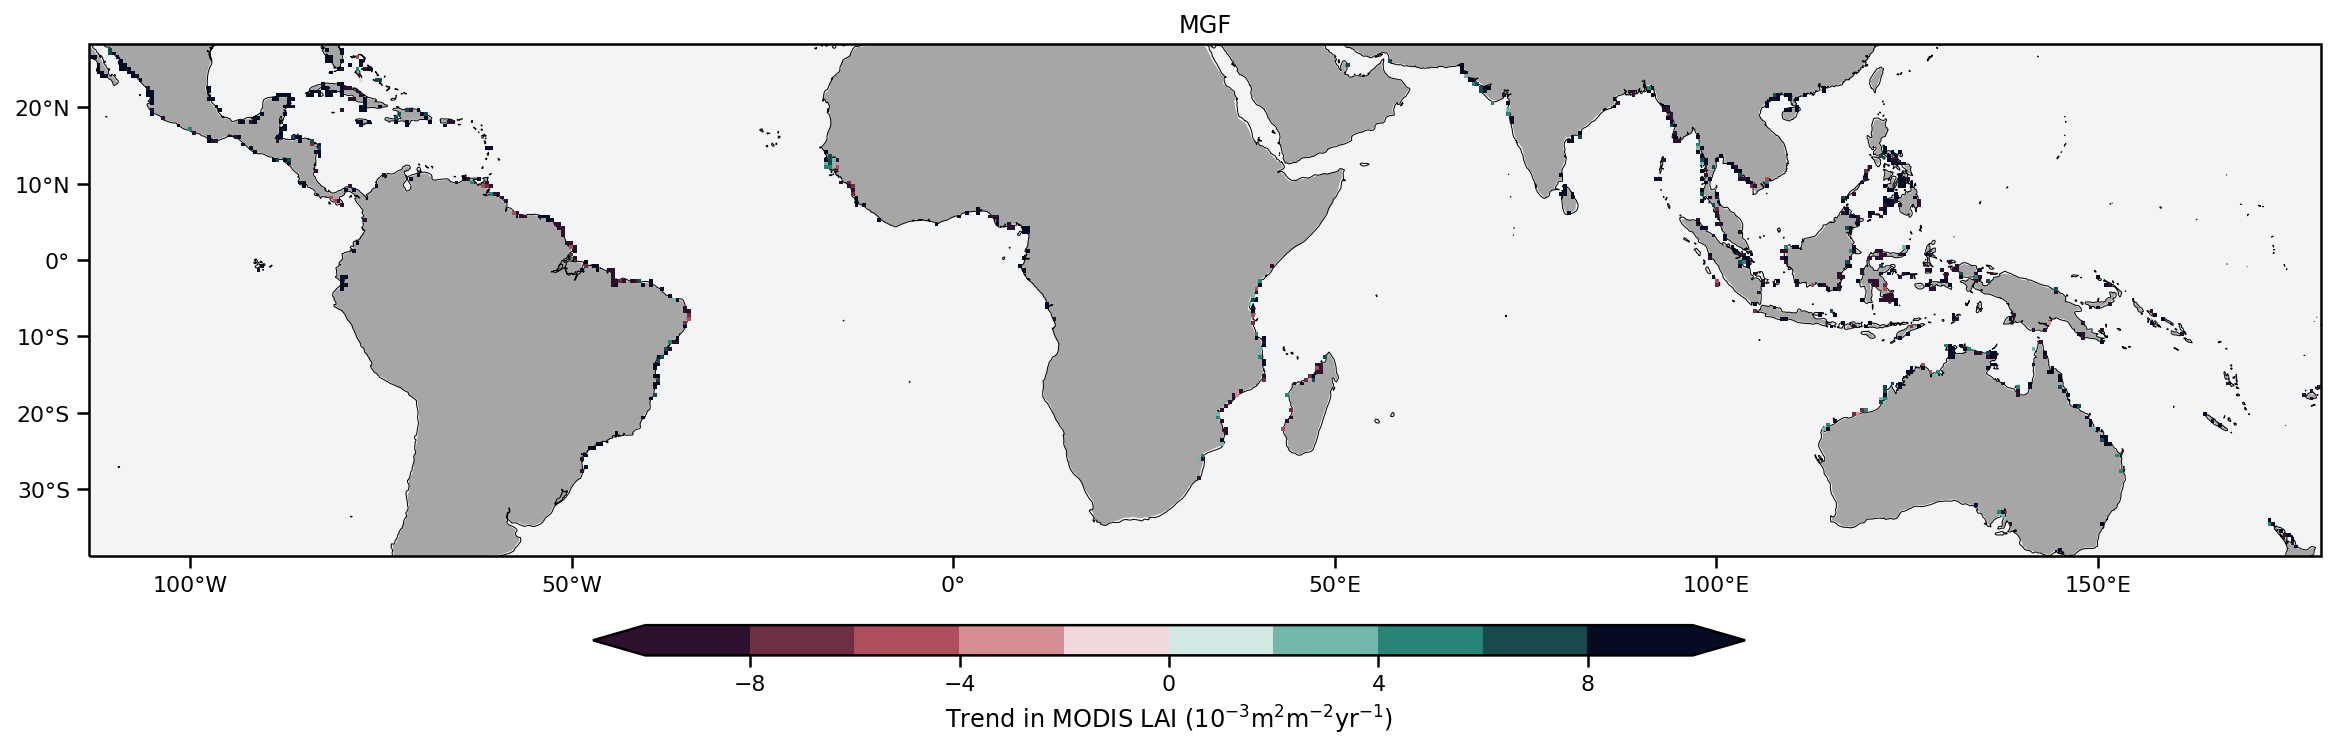

In [ ]:

fig = plt.figure(figsize=(20,7))
plt.rcParams["font.family"] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
proj = ccrs.PlateCarree()
ax = fig.add_subplot(111, projection=proj)
ax.set_extent([lon.min(),lon.max(),lat.min(),lat.max()],proj)
ax.coastlines(resolution = '50m',color='k',zorder=1,lw=0.5)
ax.add_feature(cfeature.LAND,color='#a6a6a6')
ax.add_feature(cfeature.OCEAN,color='#f3f4f6')
ax.set_title('MGF')
map_ivt = ax.imshow(MGF,extent=[lon.min(),lon.max(),lat.min(),lat.max()],cmap=cmap ,aspect='equal',zorder=3,norm = norm)
ax.set_xticks(np.arange(-100,160,50), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-30,21,10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
position = fig.add_axes([0.3, 0.15, 0.4, 0.03 ])#位置[左,下,右,上]
cb = fig.colorbar(map_ivt, cax=position, orientation='horizontal',extend='both',label='Trend in MODIS LAI (10$^{-3}$m$^2$m$^{-2}$yr$^{-1}$)')
# plt.savefig('/content/drive/MyDrive/Greenness/FigureCollection/MGF_sig10.png',dpi=600,bbox_inches='tight')
plt.show()

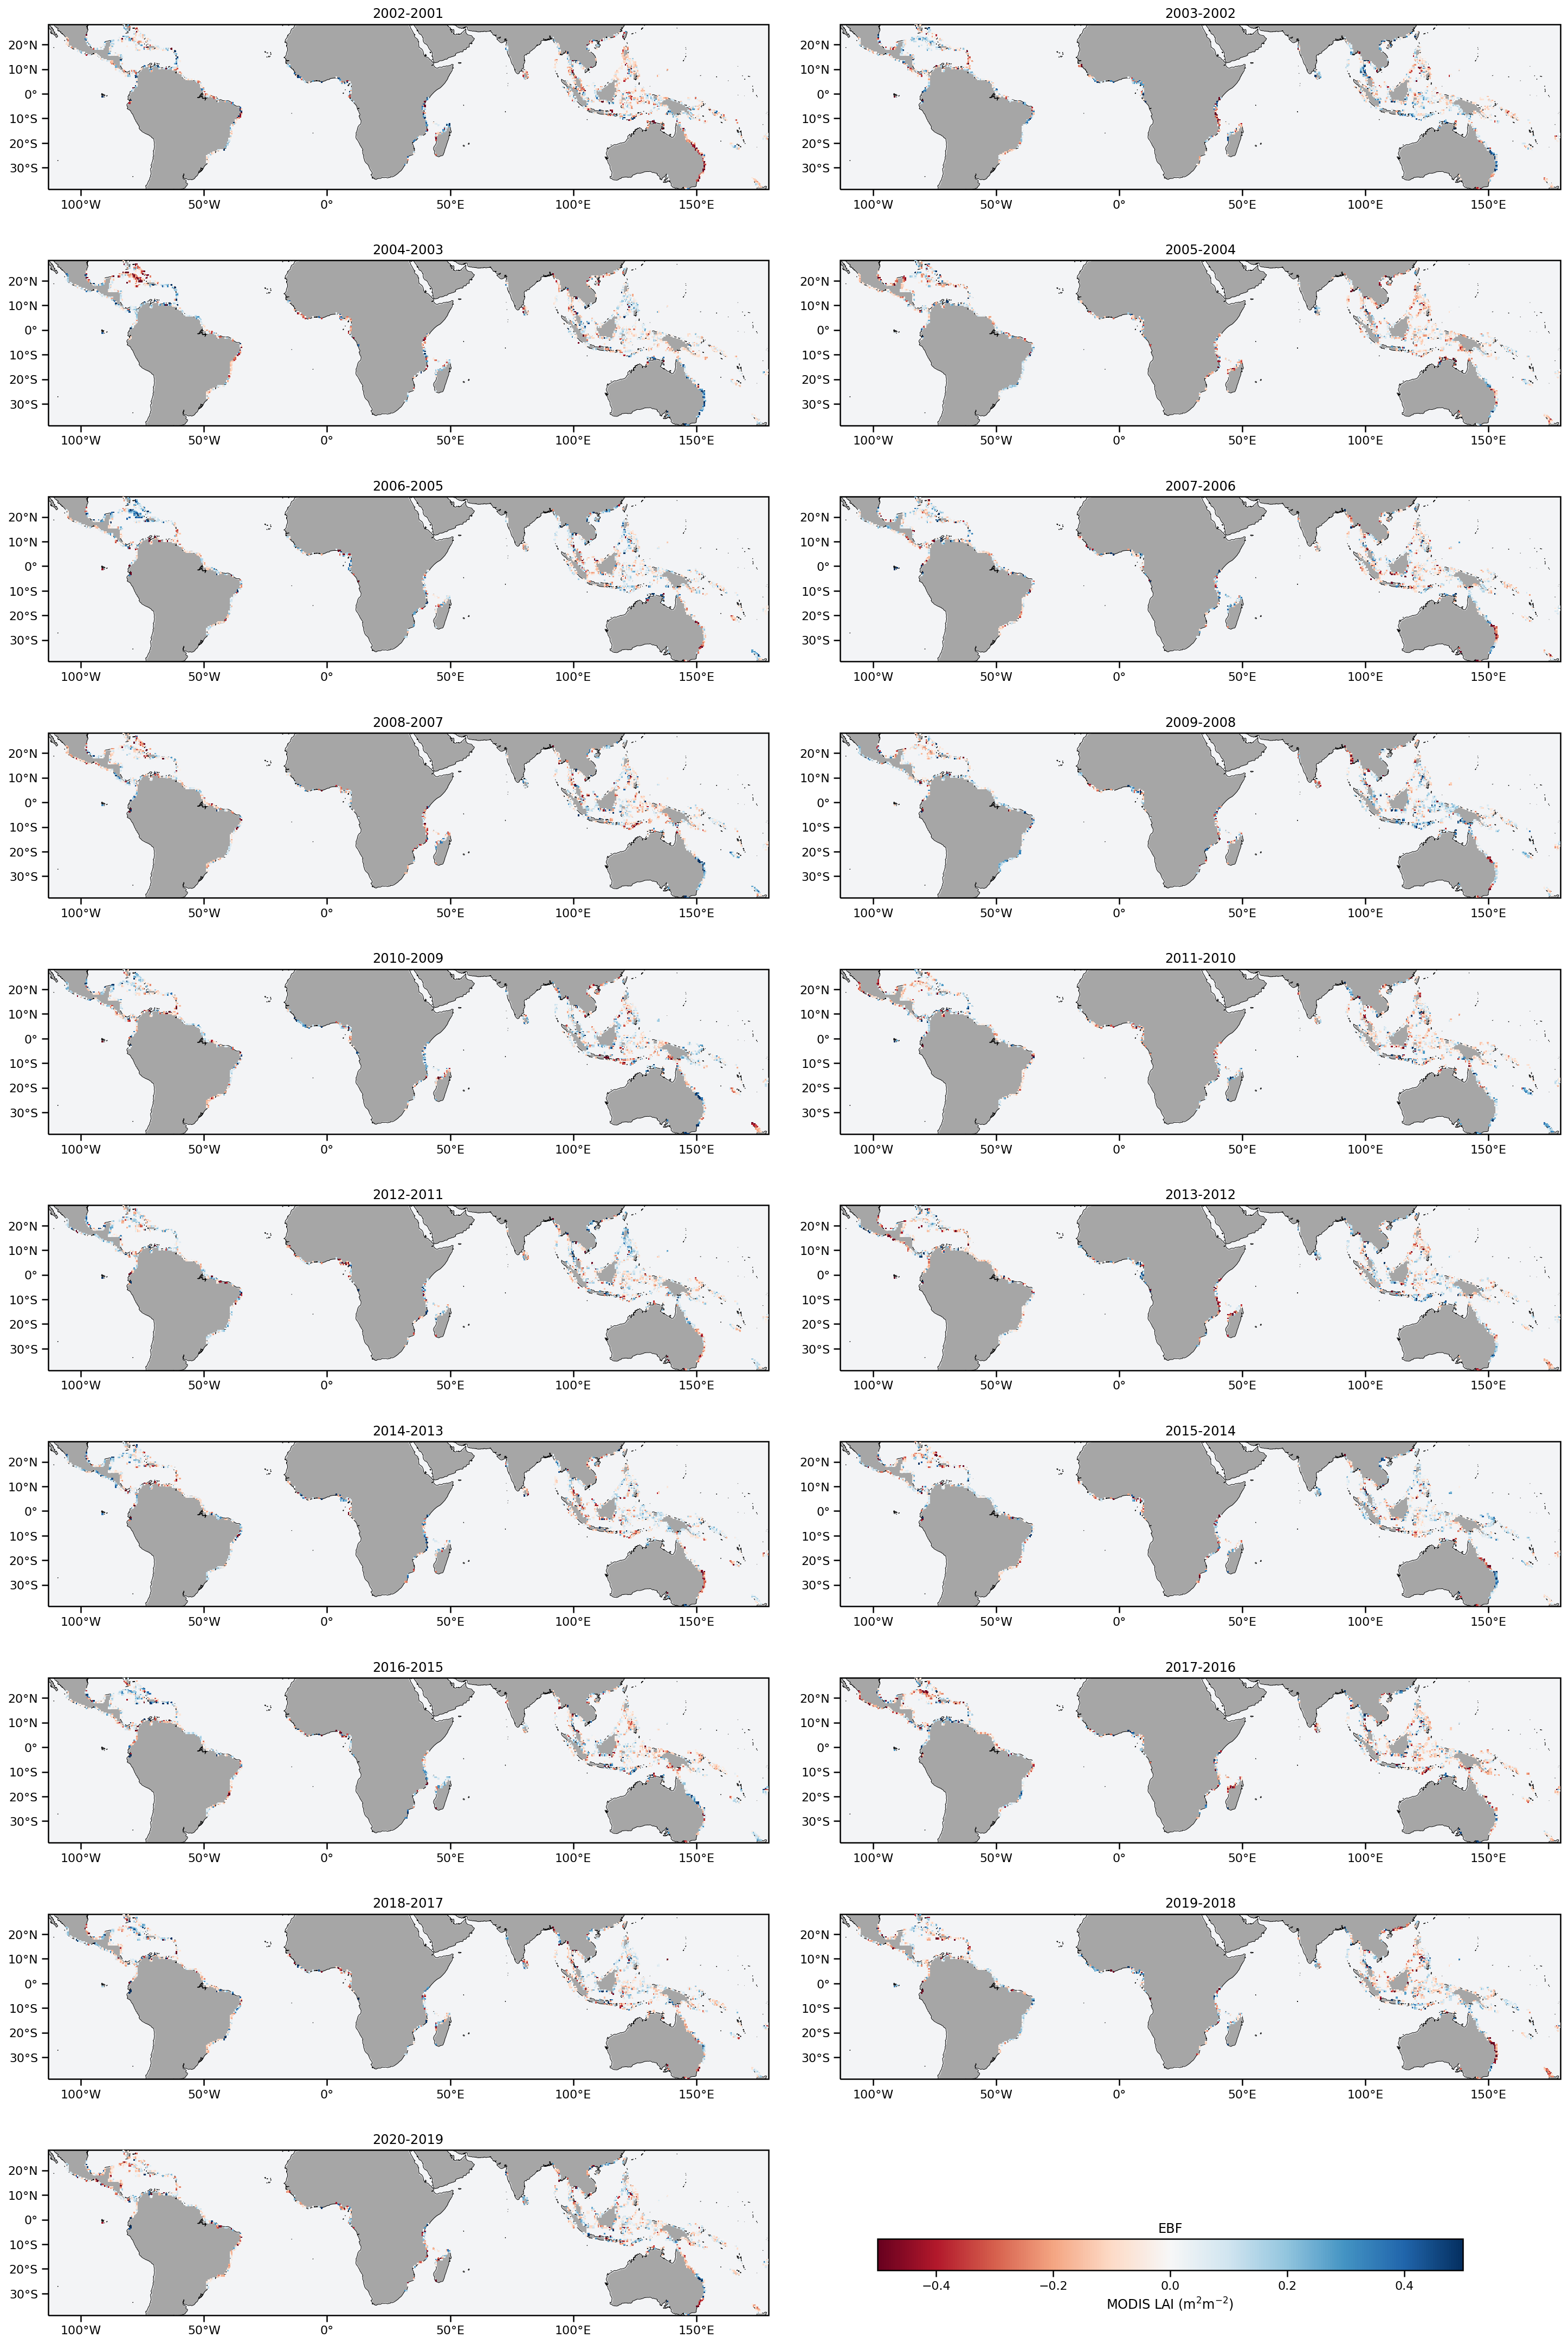

CPU times: user 53.7 s, sys: 1.06 s, total: 54.8 s
Wall time: 55.8 s


In [ ]:
%%time
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(25,40))
for i,year in enumerate(range(2002,2021)):
  ax = fig.add_subplot(10,2,1+i, projection=proj)
  ds = xr.open_rasterio('/content/drive/MyDrive/Greenness/EBF/{0}_LAI_05deg.tif'.format(year))
  ds = ds.where(ds>0)
  ds2 = xr.open_rasterio('/content/drive/MyDrive/Greenness/EBF/{0}_LAI_05deg.tif'.format(year-1))
  ds2 = ds2.where(ds2>0)
  lai=(ds-ds2)/1000
  lon = ds.x.data
  lat = ds.y.data
  ax.set_extent([lon.min(),lon.max(),lat.min(),lat.max()],proj)
  ax.coastlines(resolution = '50m',color='k',zorder=1,lw=0.5)
  ax.add_feature(cfeature.LAND,color='#a6a6a6')
  ax.add_feature(cfeature.OCEAN,color='#f3f4f6')
  map_ivt = lai.plot(cmap='RdBu',zorder=3,vmax=0.5,vmin=-0.5,ax=ax, add_colorbar=False)
  ax.set_title(str(year)+'-'+str(year-1))
  # map_ivt = ax.imshow(lai,extent=[lon.min(),lon.max(),lat.min(),lat.max()],cmap='YlGn' ,aspect='equal',zorder=3,vmax=6,vmin=0.19)
  ax.set_xticks(np.arange(-100,160,50), crs=ccrs.PlateCarree())
  ax.set_yticks(np.arange(-30,21,10), crs=ccrs.PlateCarree())
  ax.set_xlabel('')
  ax.set_ylabel('')
  lon_formatter = LongitudeFormatter(zero_direction_label=False)
  lat_formatter = LatitudeFormatter()
  ax.xaxis.set_major_formatter(lon_formatter)
  ax.yaxis.set_major_formatter(lat_formatter)
position = fig.add_axes([0.55, 0.15, 0.3, 0.01 ])#位置[左,下,右,上]
cb = fig.colorbar(map_ivt, cax=position, orientation='horizontal',extend='neither',label='MODIS LAI (m$^2$m$^{-2}$)')
plt.subplots_adjust(wspace =0.1, hspace =0.02)
plt.title('EBF')
plt.savefig('/content/drive/MyDrive/Greenness/FigureCollection/EBF_annualDifference.png',dpi=600,bbox_inches='tight')
plt.show()

In [ ]:
lai[~np.isnan(lai)]

array([4.2560534, 2.551903 , 4.2459407, ..., 4.0503893, 4.271882 ,
       3.8344643], dtype=float32)